# Figure S2A-C
The goal of this experiment is to show that the fish performs directional swimming in response to rotational stimuli.

Fish experienced 45-s long closed-loop rotational motion with different angular velocities. The gain of closed-loop was set to 0.3.

Please see **Table S1** for the detail of the stimulus structure.

In [1]:
# Import packages
import numpy as np
import os
from bouter import EmbeddedExperiment
from matplotlib import pyplot as plt
import colorcet as cc
from tqdm import tqdm
from homr_util import *

In [2]:
# Tweaking matplotlib 
set_rcParams()

In [3]:
# Find data
data_dir = "./data/figS2_01"
fish_list = os.listdir(data_dir)
n_fish = len(fish_list)
print('total',n_fish,'fish')

total 22 fish


## Analysis
- Loop around the fish directories, load behavioral data (i.e. swim effort)
- For each 45-s long epoch, take all bouts and sum the bout biases

In [4]:
all_stim_vel = []
all_turn_rate = []

for fish in tqdm(fish_list):
    
    # load data
    exp = EmbeddedExperiment(data_dir + '/' + fish)
    slog = exp['stimulus']['log']
    
    ## time trace extraction
    # timestamp
    t_s = exp.stimulus_log['t'].to_numpy()
    # Extract bout biases
    # Here, we trust behavior estimated for on-line closed loop
    # "fish_theta" is a rolling average of tail angle (within 70 ms windows)
    # "start_theta_update" is boolean, which is only TRUE at 70 ms after the bout onset (i.e. the moment vigor surpassed 0.05 rad)
    # By multiplying them together, we get the "spikes" of values whose timing and height indicate the bout timimng and bias, respectively
    turn_spike = exp.stimulus_log['seamless_image_fish_theta'].to_numpy() * exp.stimulus_log['seamless_image_start_theta_update'].to_numpy() / np.pi * 180 # in deg
    
    stim_vel = []
    turn_rate = []
    
    # loop through epochs, calculate averaged turning bias
    # by dividing the summed bout biases by the epoch duration
    # (note this is in the 'motor' unit, as we are not applying the closed loop gain)
    for epoch in slog:
        t_start = epoch['t_start']
        t_end = t_start + epoch['duration']
        is_this_epoch = (t_s>=t_start) * (t_s<t_end)
        stim_vel.append(epoch['vel_drift'] / np.pi * 180)
        turn_rate.append(np.nansum(turn_spike[is_this_epoch]) / epoch['duration'])
        
    all_stim_vel.append(np.asarray(stim_vel))
    all_turn_rate.append(np.asarray(turn_rate))

100%|████████████████████████████████████████████████████████████████████████| 22/22 [00:01<00:00, 11.17it/s]


In [5]:
# do lienar regression of turn bias by stimulus angular velocity
betas = [np.linalg.lstsq(x[None,:].T, y[None,:].T, rcond=None)[0][0][0] for x, y in zip(all_stim_vel, all_turn_rate)]

## Panels
### Fig. S2A (Individual fish example)

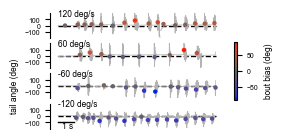

In [6]:
# example fish
fid = 9

# re-load raw data, because we discarded them
fish = fish_list[fid]
exp = EmbeddedExperiment(data_dir + '/' + fish)
slog = exp['stimulus']['log']

## time trace extraction
t_s = exp.stimulus_log['t'].to_numpy() # time axis for stimulus (60Hz-ish)
t_b = exp.behavior_log['t'].to_numpy() # time axis for behavioral recordings (200Hz-ish)

# pull out bout spikes
turn_spike = exp.stimulus_log['seamless_image_fish_theta'].to_numpy() * exp.stimulus_log['seamless_image_start_theta_update'].to_numpy() / np.pi * 180
# pull out indices of when spikes happened
i_bout = np.where(np.abs(turn_spike)>0)
# calculate when spikes happened
t_bout = t_s[i_bout]-0.07
# get the biases of the spikes
bout_bias = turn_spike[i_bout]

# the original tail trace
tail_sum = exp.behavior_log['tail_sum'].to_numpy() / np.pi * 180

# Example epochs that looked nice
epoch_ids = (13, 62, 0, 79)

fig, ax = plt.subplots(len(epoch_ids), 1, figsize=(2.8,1.5))
vis_dur = 10

# Do plotting
for i, eid in enumerate(epoch_ids):
    t_start = slog[eid]['t_start']
    t_end = t_start + vis_dur
    
    ax[i].plot((0, vis_dur), (0,0), 'k--')
    ax[i].plot(t_b[(t_b>t_start)*(t_b<t_end)]-t_start, tail_sum[(t_b>t_start)*(t_b<t_end)], lw=0.5, color=(0.7, 0.7, 0.7))
    sc = ax[i].scatter(t_bout[(t_bout>t_start)*(t_bout<t_end)]-t_start, bout_bias[(t_bout>t_start)*(t_bout<t_end)], 
                  c=bout_bias[(t_bout>t_start)*(t_bout<t_end)], zorder=3, vmin=-90, vmax=90, cmap=cc.cm.CET_D8, s=10)
    
    ax[i].text(0, 150, '{} deg/s'.format(int(slog[eid]['vel_drift']/np.pi*180)))
    
    ax[i].set_ylim([-200,200])
    ax[i].set_yticks([-100,0,100])
    
    toggle_spines(ax[i], 0, 0, 0, 1)
    
ax[len(epoch_ids)//2].set_ylabel('tail angle (deg)')
ax[-1].plot((0,1),(-100,-100),'k-',lw=1)
ax[-1].text(0.25, -190, '1 s')
cb = plt.colorbar(sc, ax=ax, shrink=0.5)
cb.set_label('bout bias (deg)')

plt.savefig('./svgs/FigS2A.svg', format='svg')
plt.show()

### Fig. S2BC (Epoch-wise comparison of turn vs. stimulus, and the distribution of the slopes)

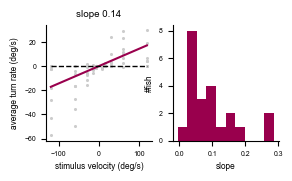

In [7]:
# S2B: Trial-wise data for the same fish (as in A)

fig, ax = plt.subplots(1, 2, figsize=(3,1.5))

ax[0].scatter(all_stim_vel[fid], all_turn_rate[fid], color=(0.8, 0.8, 0.8), s=5)
ax[0].plot([-120,120],[-120*betas[fid], 120*betas[fid]], lw=1.5, color=(0.6,0,0.3))
ax[0].plot([-120,120],[0,0], 'k--')
ax[0].set_title('slope {:0.2}'.format(betas[fid]))
ax[0].set_xlabel('stimulus velocity (deg/s)')
ax[0].set_ylabel('average turn rate (deg/s)')

# slope distribution

ax[1].hist(betas, color=(0.6, 0, 0.3))
ax[1].set_xlabel('slope')
ax[1].set_ylabel('#fish')

for axx in ax:
    toggle_spines(axx, 0, 1, 0, 1)

plt.savefig('./svgs/FigS2BC.svg', format='svg')
plt.show()